In [2]:
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

from caveat.evaluate.describe import transitions
from caveat.evaluate.describe.frequency import frequency_plots
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [ ]:
import torch

mask = torch.Tensor([[1, 1, 1, 0, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1]])
duration_mask = mask.clone()
duration_mask[:, 0] = 0.0
duration_mask[
    torch.arange(duration_mask.shape[0]), (mask != 0).cumsum(-1).argmax(1)
] = 0.0
duration_mask

tensor([[0., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.]])

In [49]:
cmap = {
    "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
    "other": (1.0, 1.0, 0.7019607843137254),
    "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
    "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
    "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
    "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
    "education": (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
    "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
    "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
}


batch_paths = {
    "Discrim": Path("../logs/TRB/discrim"),
    "C_Discrim": Path("../logs/TRB/c_discrim"),
    "VAE": Path("../logs/TRB/vae"),
    "JVAE": Path("../logs/TRB/jvae"),
    "CVAE": Path("../logs/TRB/cvae"),
    "CVAE2": Path("../logs/TRB/cvae2"),
}

# find data
target_schedules = pd.read_csv("../tmp/nts_home_schedules.csv")
acts = list(target_schedules.act.value_counts(ascending=False).index)
class_map = {n: i for i, n in enumerate(acts)}

target_attributes = pd.read_csv("../tmp/nts_home_attributes_groups.csv")


def latest(path: Path):
    versions = sorted(
        [
            d
            for d in path.iterdir()
            if d.is_dir() and d.name.startswith("version")
        ]
    )
    return path.name, versions[-1]


def iter_models(path: Path):
    for dir in path.iterdir():

        if dir.is_dir():

            yield latest(dir)


def find_nth(path: Path, n=0):

    ranks = (
        pd.read_csv(path / "domain_distances.csv")
        .drop(columns=["domain", "observed", "mean", "std"], errors="ignore")
        .rank(axis=1, method="min")
        .sum(axis=0)
    )
    ranked = [i for _, i in sorted(zip(ranks, ranks.index))]
    top = ranked[n]
    dir = path / top
    yield latest(dir)


def best_quality(path: Path, n=0):

    data = pd.read_csv(path / "domain_distances.csv")
    data = data[data.domain == "sample quality"].drop(
        columns=["domain", "observed", "mean", "std"], errors="ignore"
    )
    ranks = data.rank(axis=1, method="min").sum(axis=0)
    ranked = [i for _, i in sorted(zip(ranks, ranks.index))]
    top = ranked[n]
    dir = path / top
    yield latest(dir)


def load_attributes(path: Path, default=None):
    if (path / "synthetic_attributes.csv").exists():
        print(f"Loading synthetic attributes from {path}")
        return pd.read_csv(path / "synthetic_attributes.csv")
    if (path / "synthetic_labels.csv").exists():
        print(f"Loading synthetic labels from {path}")
        return pd.read_csv(path / "synthetic_labels.csv")
    print(f"Failed to find attributes at {path}")
    return default


next(find_nth(Path("../logs/paper_d_rnn")))

('DiscLSTM5', PosixPath('../logs/paper_d_rnn/DiscLSTM5/version_1'))

In [50]:
schedules = {
    n: pd.read_csv(next(best_quality(p, 0))[1] / "synthetic_schedules.csv")
    for n, p in batch_paths.items()
}
attributes = {
    n: load_attributes(next(best_quality(p, 0))[1], default=target_attributes)
    for n, p in batch_paths.items()
}

Loading synthetic attributes from ../logs/TRB/discrim/discrim_nrun0/version_0
Loading synthetic attributes from ../logs/TRB/c_discrim/c_discrim_nrun0/version_0
Failed to find attributes at ../logs/TRB/vae/vae_nrun0/version_0
Loading synthetic labels from ../logs/TRB/jvae/jvae_nrun0/version_0
Loading synthetic attributes from ../logs/TRB/cvae/cvae_nrun2/version_0
Loading synthetic attributes from ../logs/TRB/cvae2/cvae2_nrun2/version_0


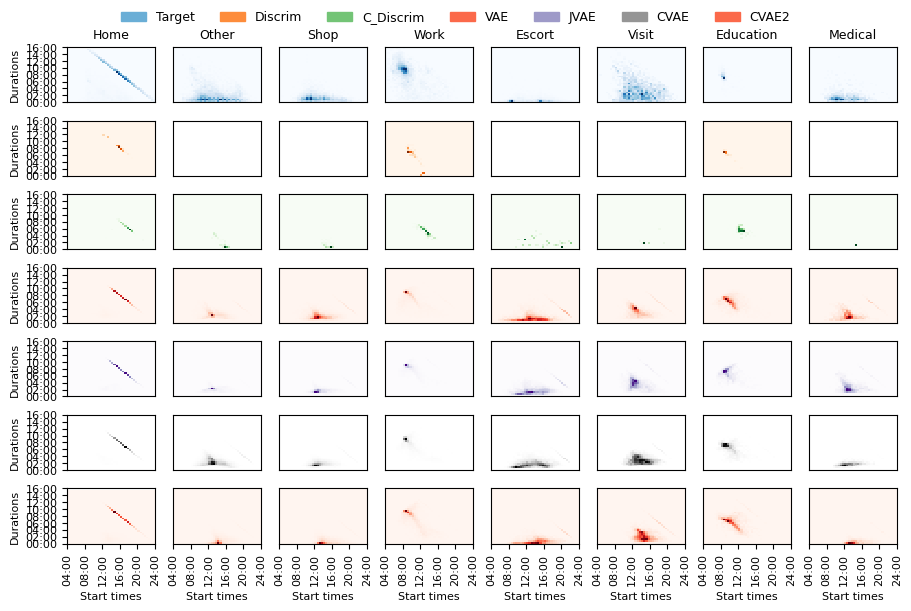

In [51]:
fig = joint_time_distributions_plot(
    target_schedules,
    schedules,
    figsize=(9, 6),
    observed_title="Target",
    cmaps={
        0: "Blues",
        1: "Oranges",
        2: "Greens",
        3: "Reds",
        4: "Purples",
        5: "Greys",
    },
)

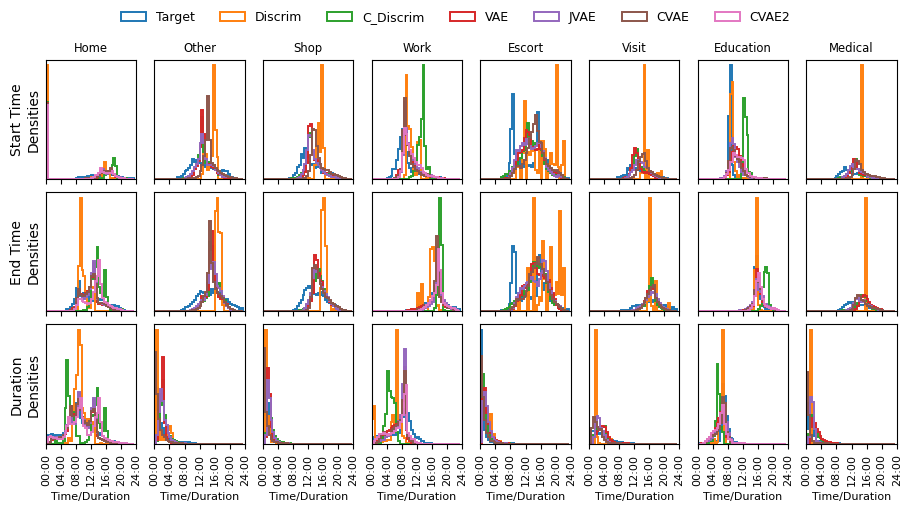

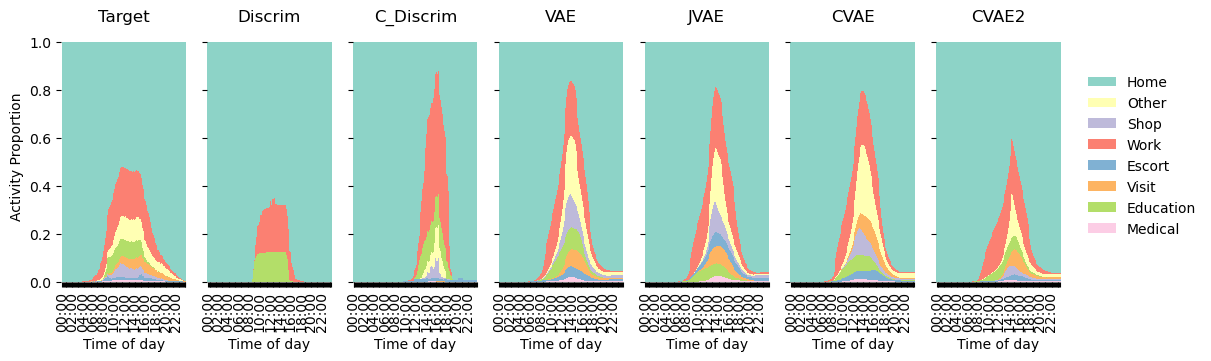

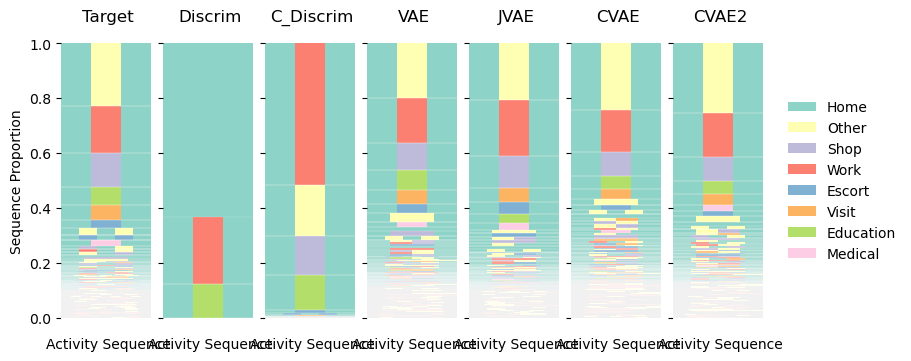

In [52]:
fig = times_distributions_plot(
    target_schedules, schedules, observed_title="Target", figsize=(9, 5)
)
fig = frequency_plots(
    target_schedules,
    schedules,
    color=cmap,
    figsize=(12, 3.5),
    observed_title="Target",
)
fig = sequence_prob_plot(
    target_schedules,
    schedules,
    cmap=cmap,
    figsize=(9, 3.5),
    observed_title="Target",
)

In [35]:
import random

from pam.core import Household, Person
from pam.plot.plans import plot_household

from caveat.data.utils import trace_to_pam


def stretch(schedules):
    return schedules.groupby(schedules.pid).apply(stretcher)


def stretcher(schedule):
    duration = schedule.duration.sum()
    if duration != 1440:
        a = 1440 / duration
        schedule.duration = (schedule.duration * a).astype(int)
        accumulated = list(schedule.duration.cumsum())
        schedule.start = [0] + accumulated[:-1]
        schedule.end = accumulated
    return schedule


def trim(schedules):
    schedules[schedules.end > 1440] = 1440
    schedules[schedules.start > 1440] = 1440
    schedules.duration = schedules.end - schedules.start
    schedules = schedules[schedules.duration > 0]
    return schedules


def pad(schedules):
    return (
        schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
    )


def padder(schedule):
    if schedule.end.iloc[-1] < 1440 and schedule.act.iloc[-1] != "home":
        pid = schedule.pid.iloc[0]
        schedule = pd.concat(
            [
                schedule,
                DataFrame(
                    {
                        "pid": pid,
                        "start": schedule.end.iloc[-1],
                        "end": 1440,
                        "duration": 1440 - schedule.end.iloc[-1],
                        "act": "home",
                    },
                    index=[0],
                ),
            ]
        )
    elif schedule.end.iloc[-1] < 1440:
        schedule.end.iloc[-1] = 1440
        schedule.duration.iloc[-1] = 1440 - schedule.start.iloc[-1]
    return schedule


def plot_schedules(schedules, **kwargs):

    cmap = {
        "home": (0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
        "other": (1.0, 1.0, 0.7019607843137254),
        "shop": (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
        "work": (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
        "escort": (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
        "visit": (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
        "education": (
            0.7019607843137254,
            0.8705882352941177,
            0.4117647058823529,
        ),
        "medical": (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
        "travel": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    }
    cmap = {n.title(): c for n, c in cmap.items()}

    hh = Household("")

    pids = schedules.pid
    selected = random.sample(list(pids), 5)
    for i, pid in enumerate(selected):
        person = Person(pid)
        plan = schedules[schedules.pid == pid]
        plan = trim(stretch(pad(plan)))[["act", "start", "end", "duration"]]
        mapping = {a: a for a in plan.act}

        trace = [
            (row.act, row.start, row.end, row.duration)
            for i, row in plan.iterrows()
        ]
        plan = trace_to_pam(trace, mapping)

        person = Person(i)
        person.plan = plan
        hh.add(person)

    plot_household(hh, cmap=cmap, width=25)

/tmp/ipykernel_3536130/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_3536130/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_3536130/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the groupi

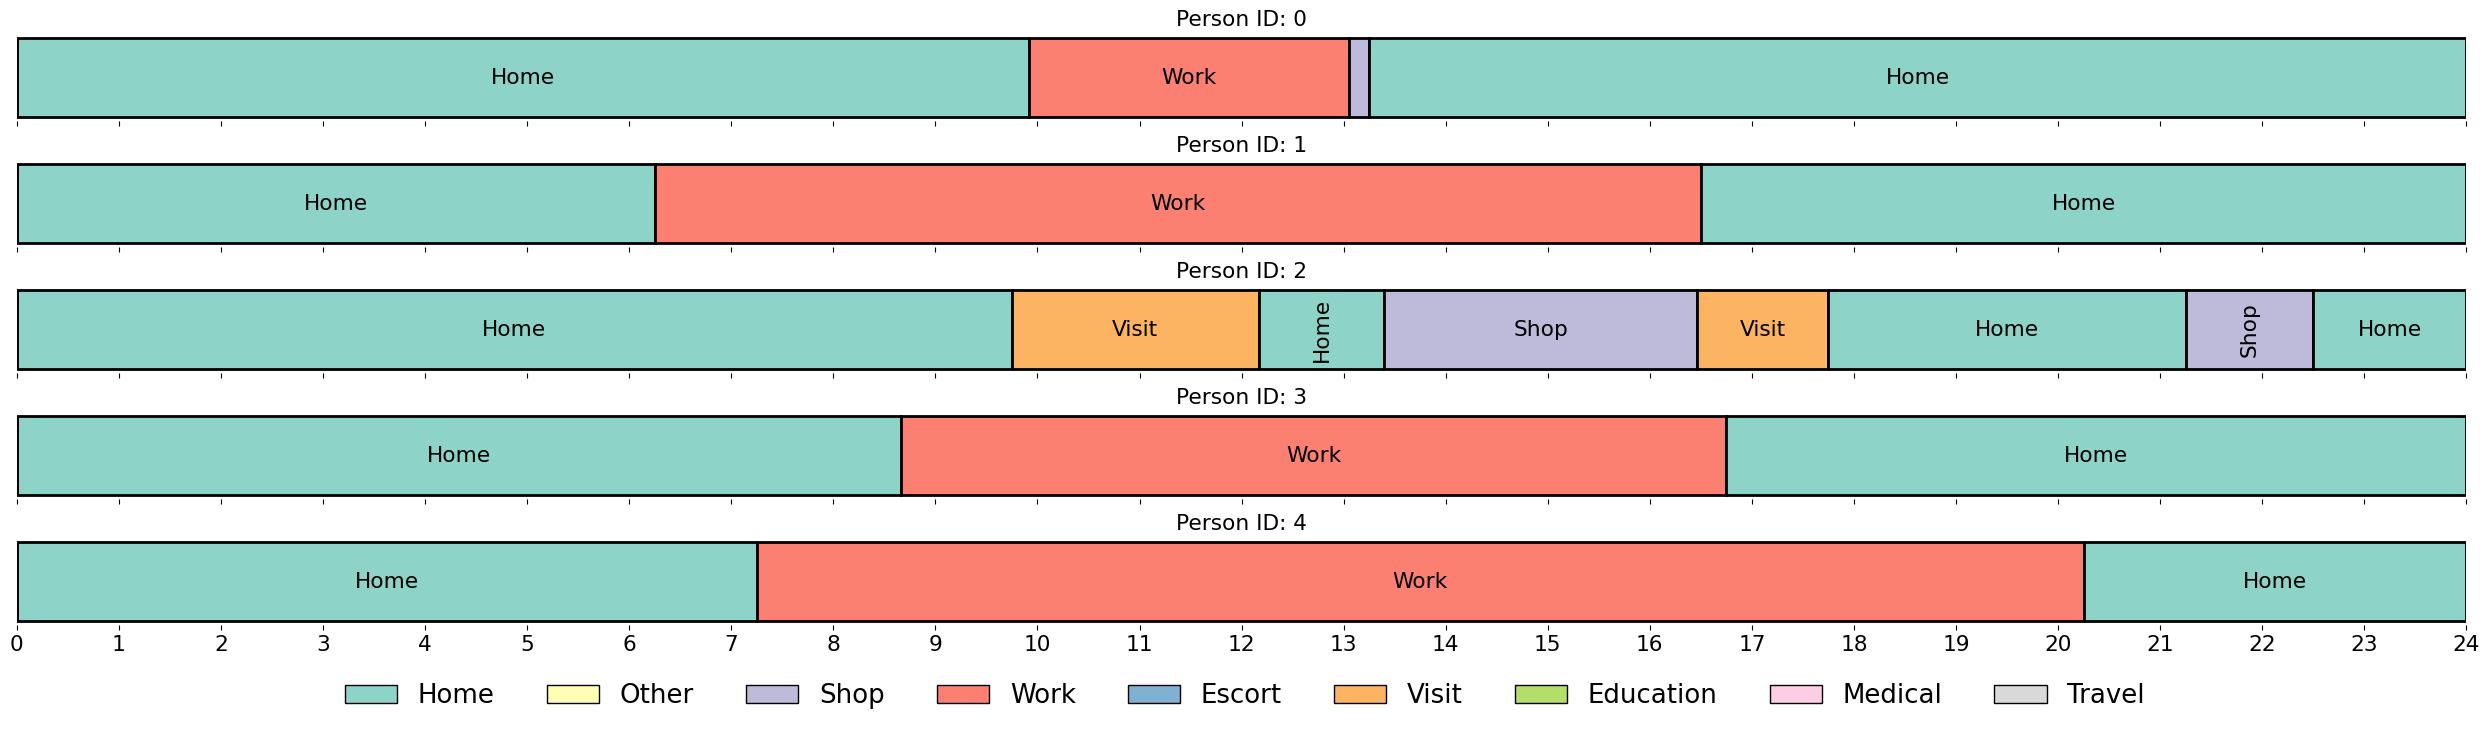

In [36]:
plot_schedules(target_schedules)

/tmp/ipykernel_3536130/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  schedules.groupby(schedules["pid"]).apply(padder).reset_index(drop=True)
/tmp/ipykernel_3536130/1738895634.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return schedules.groupby(schedules.pid).apply(stretcher)
/tmp/ipykernel_3536130/1738895634.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the groupi

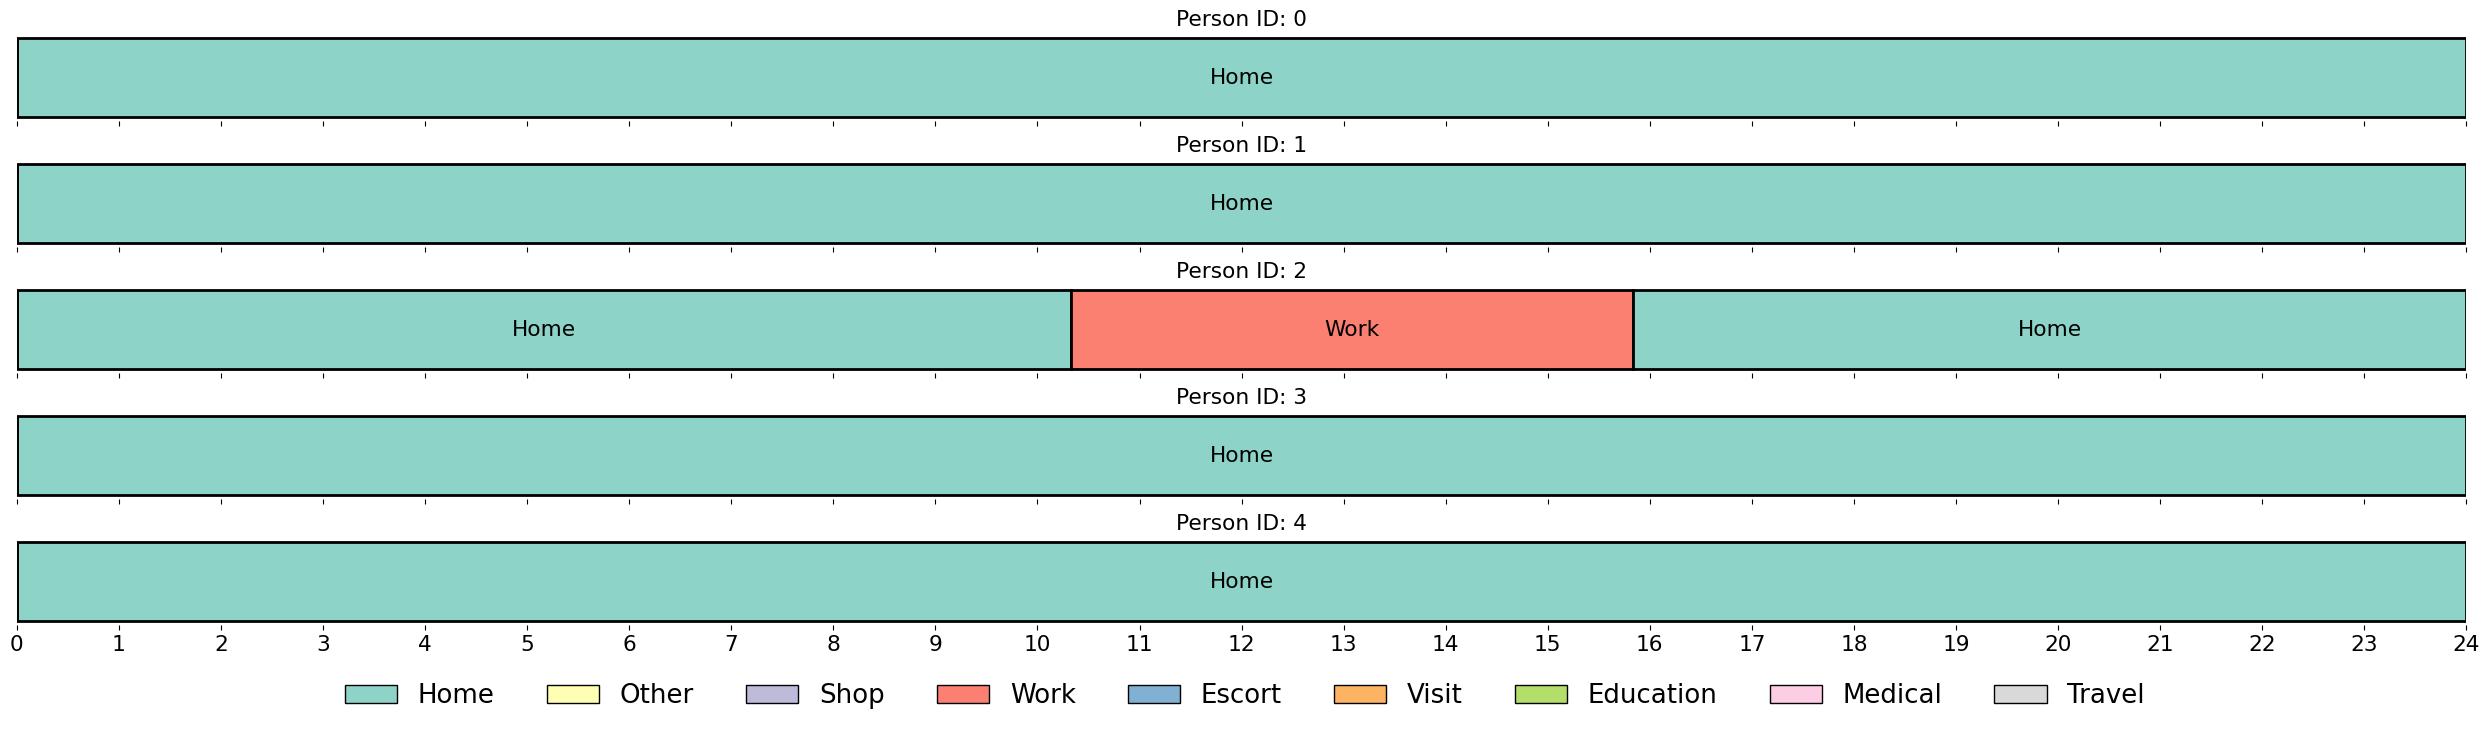

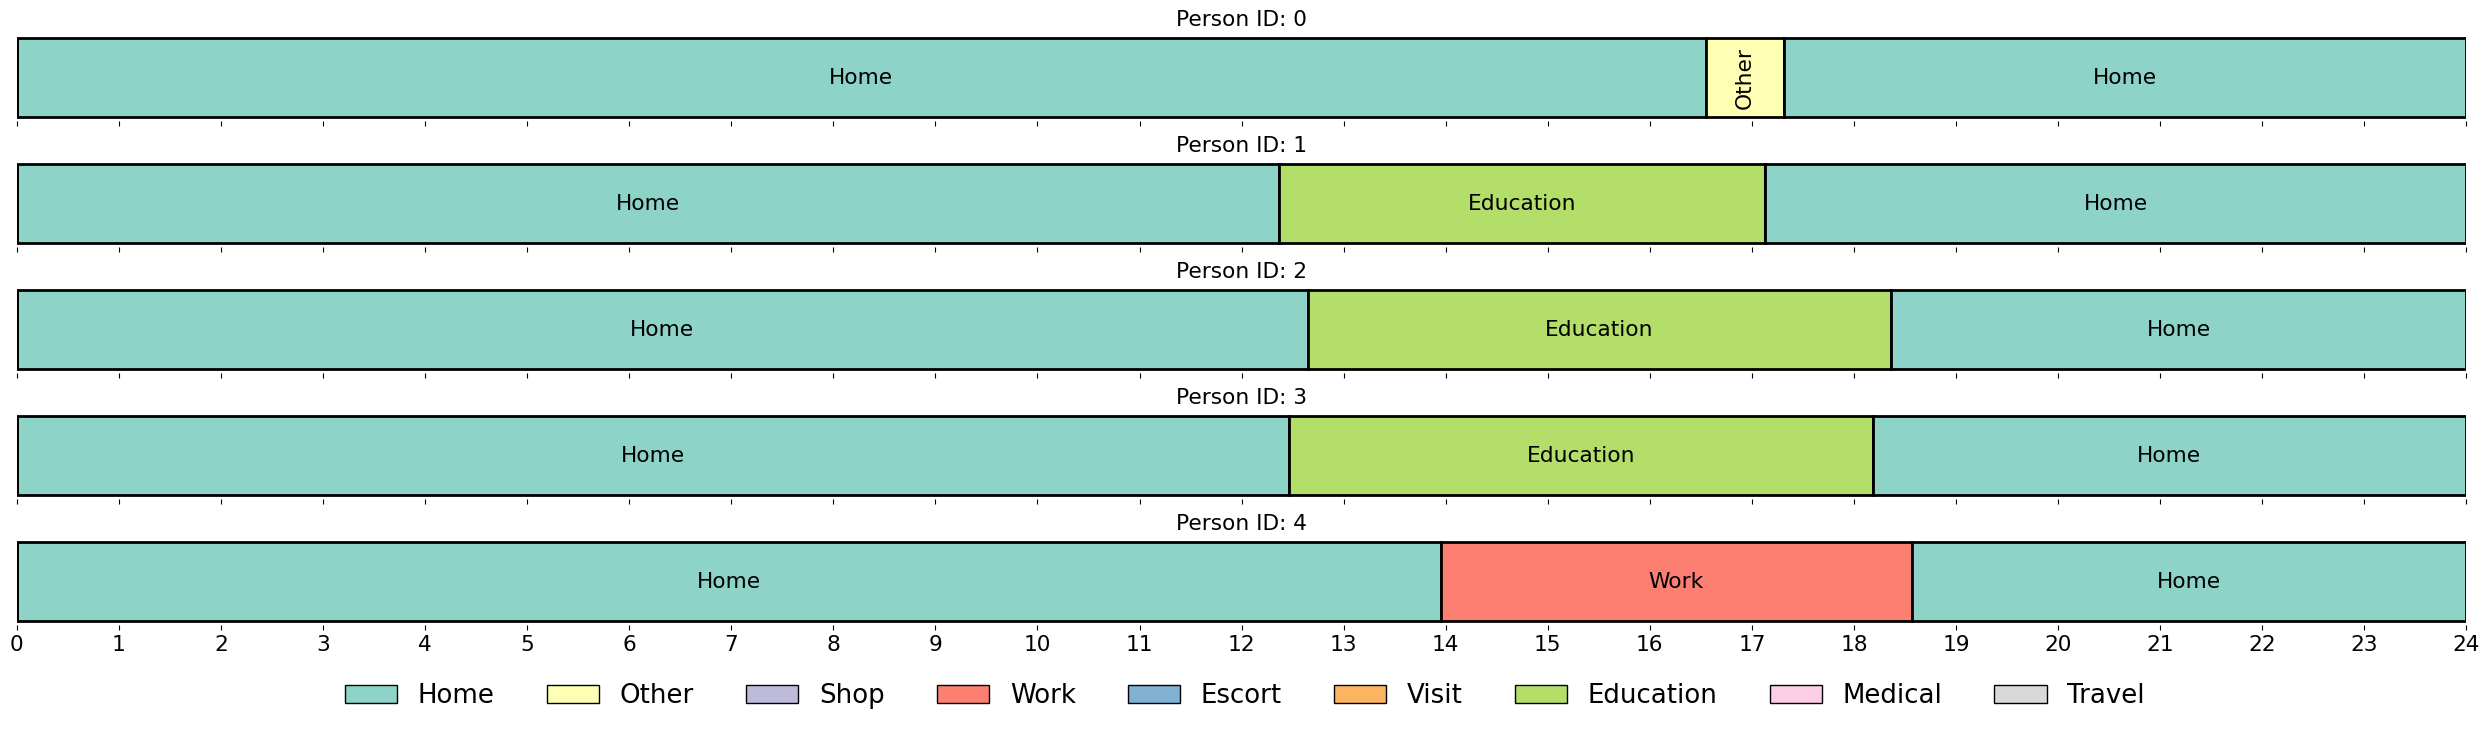

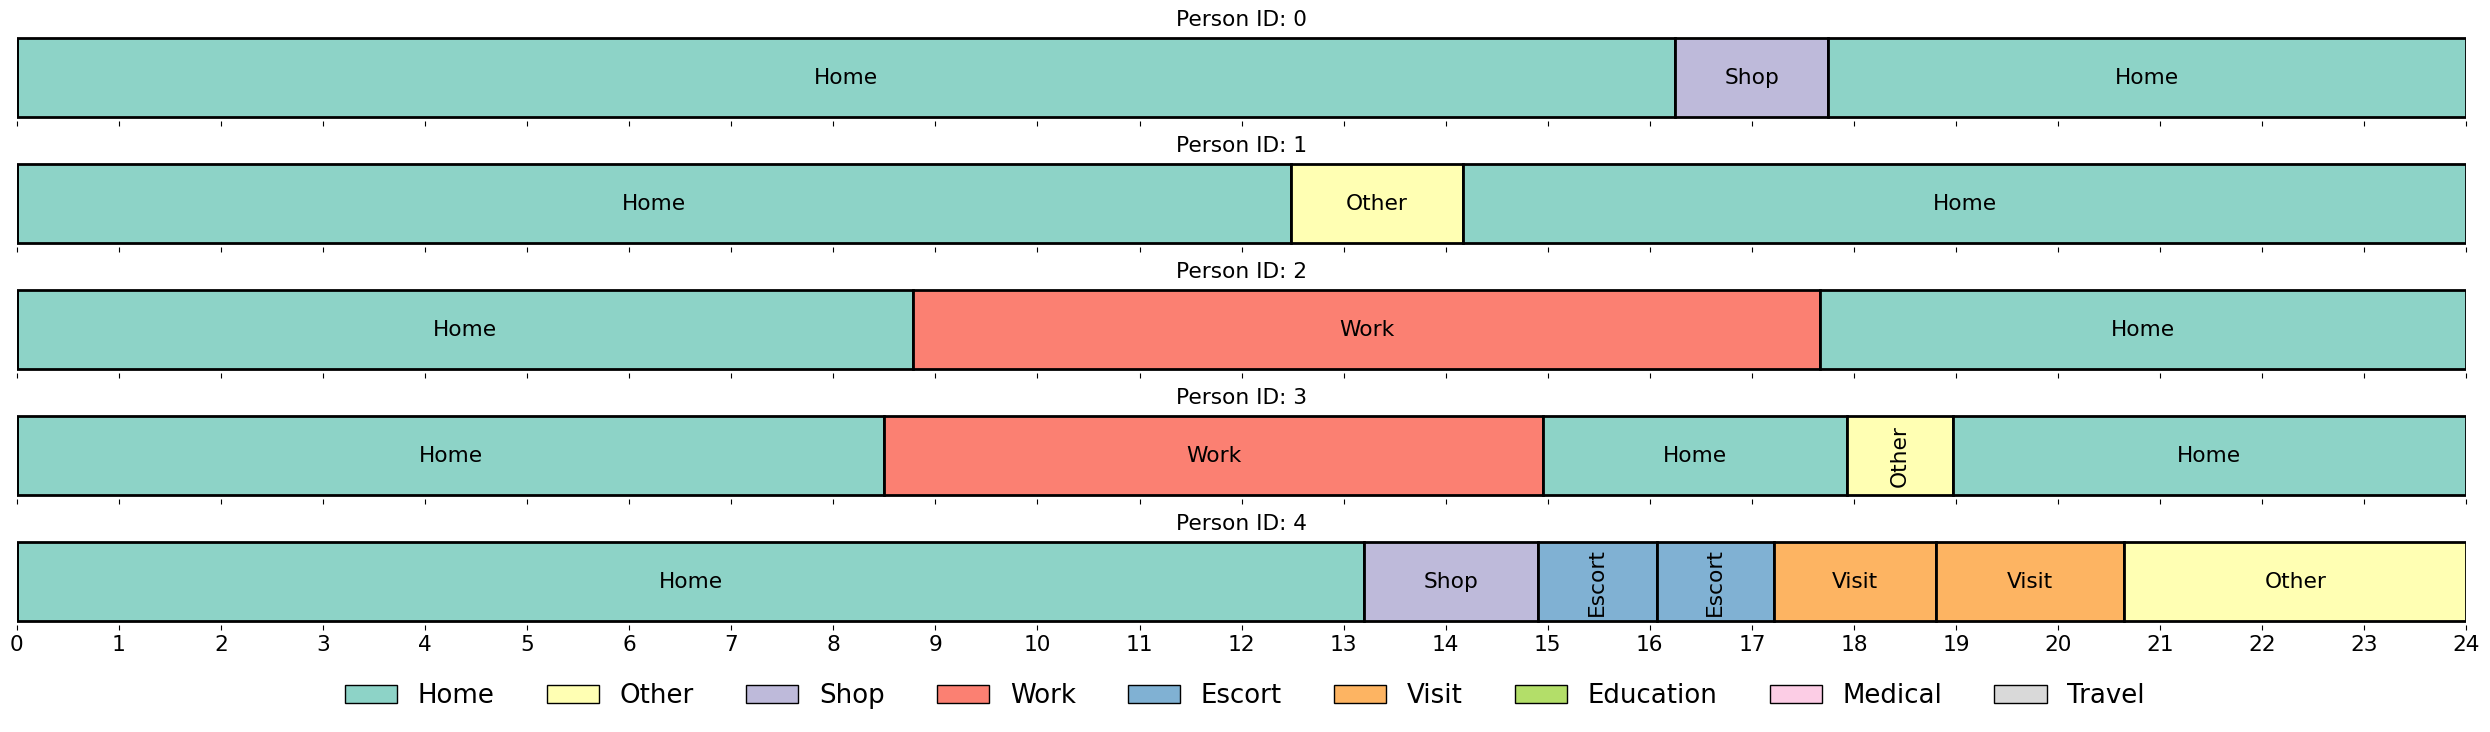

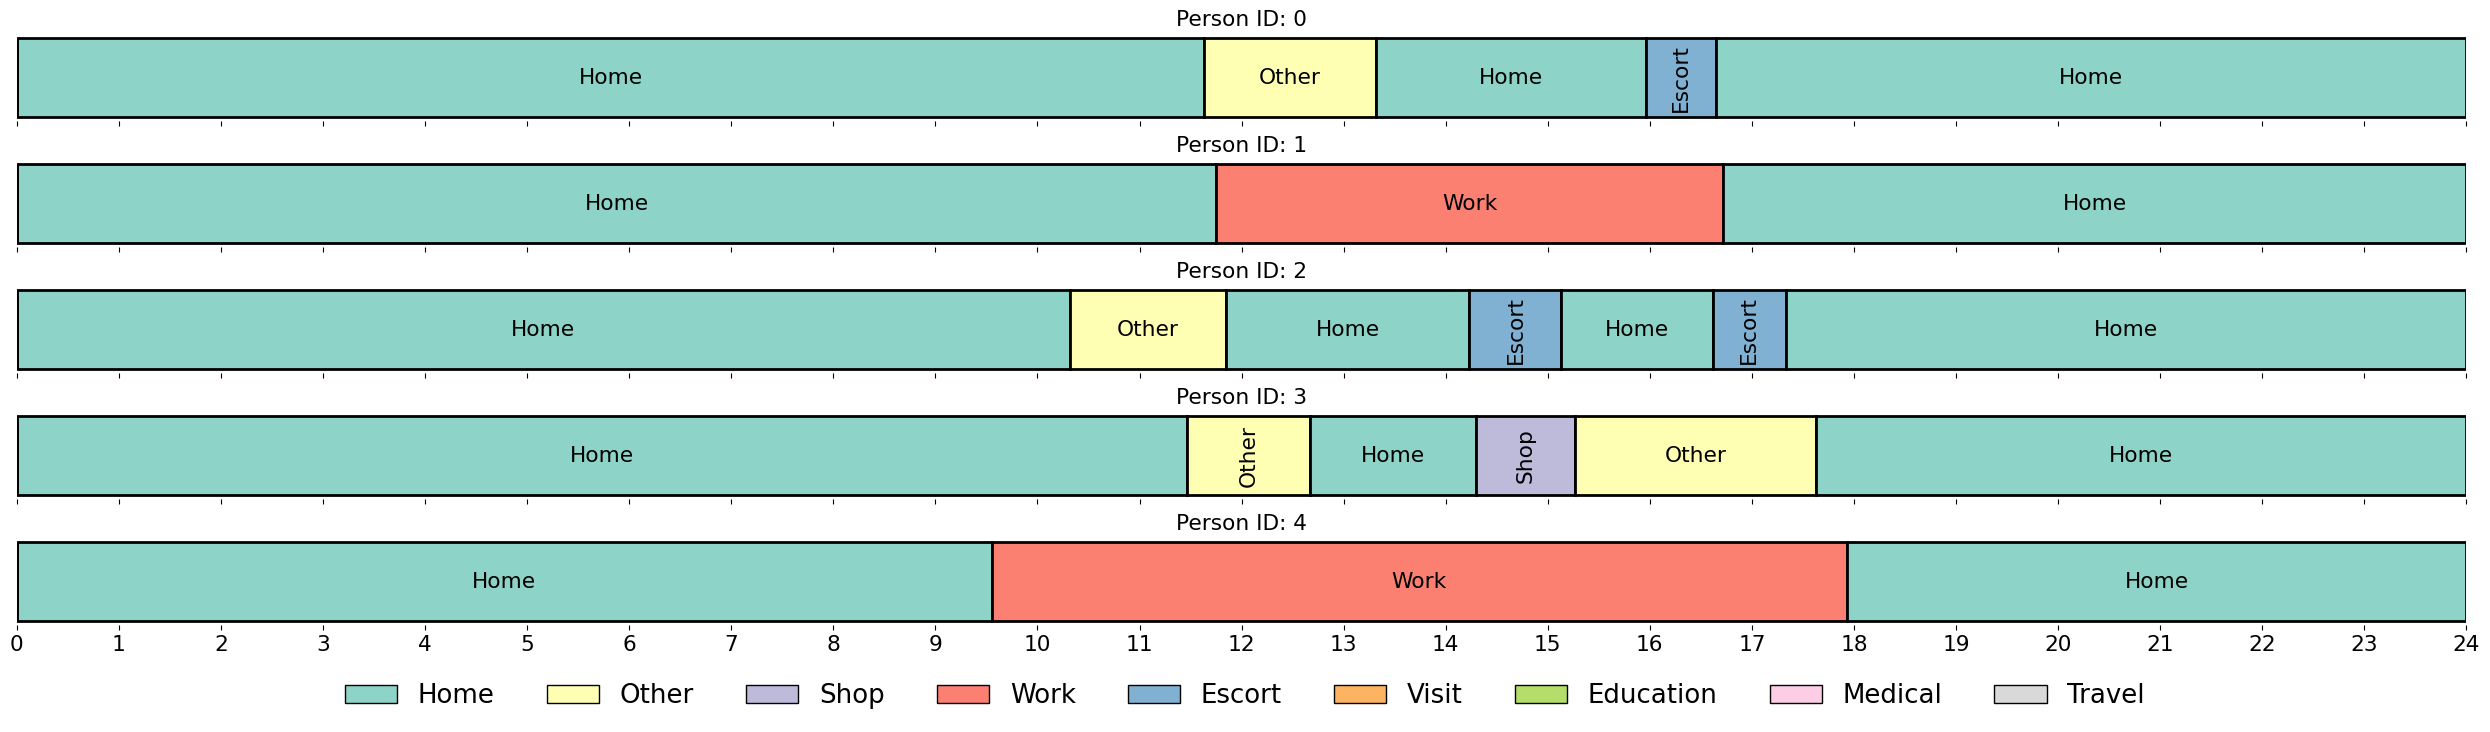

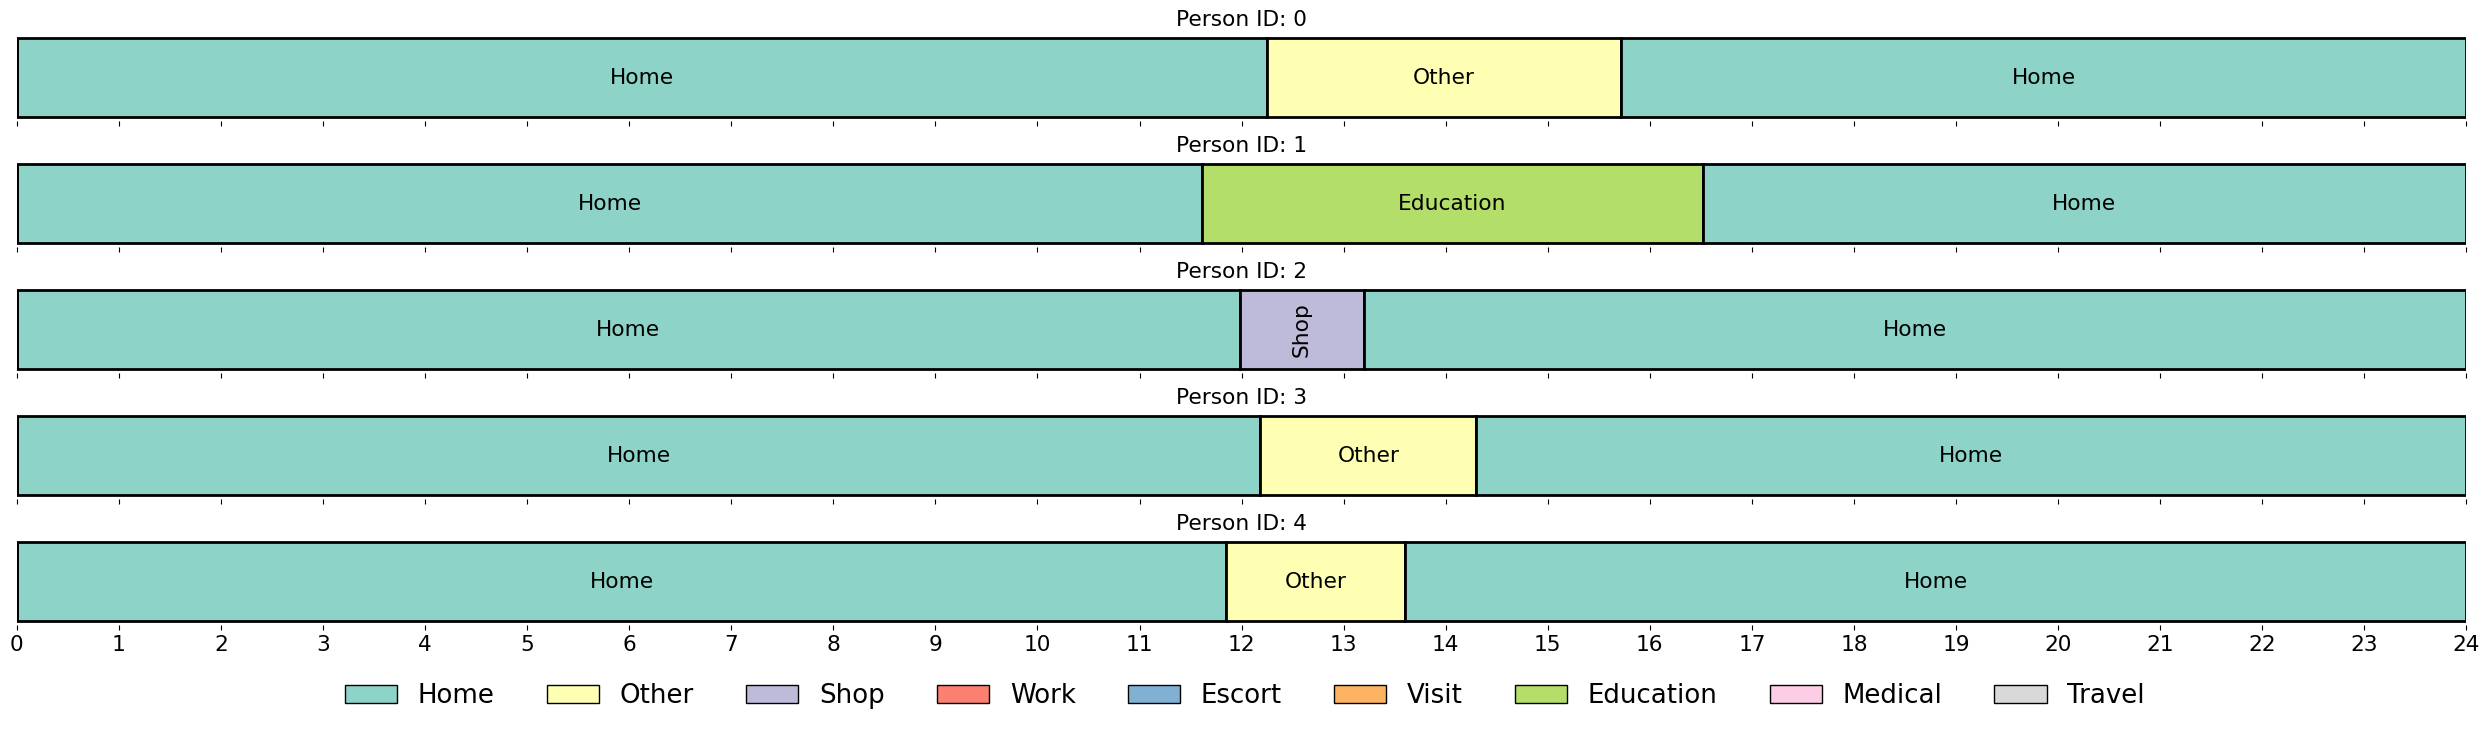

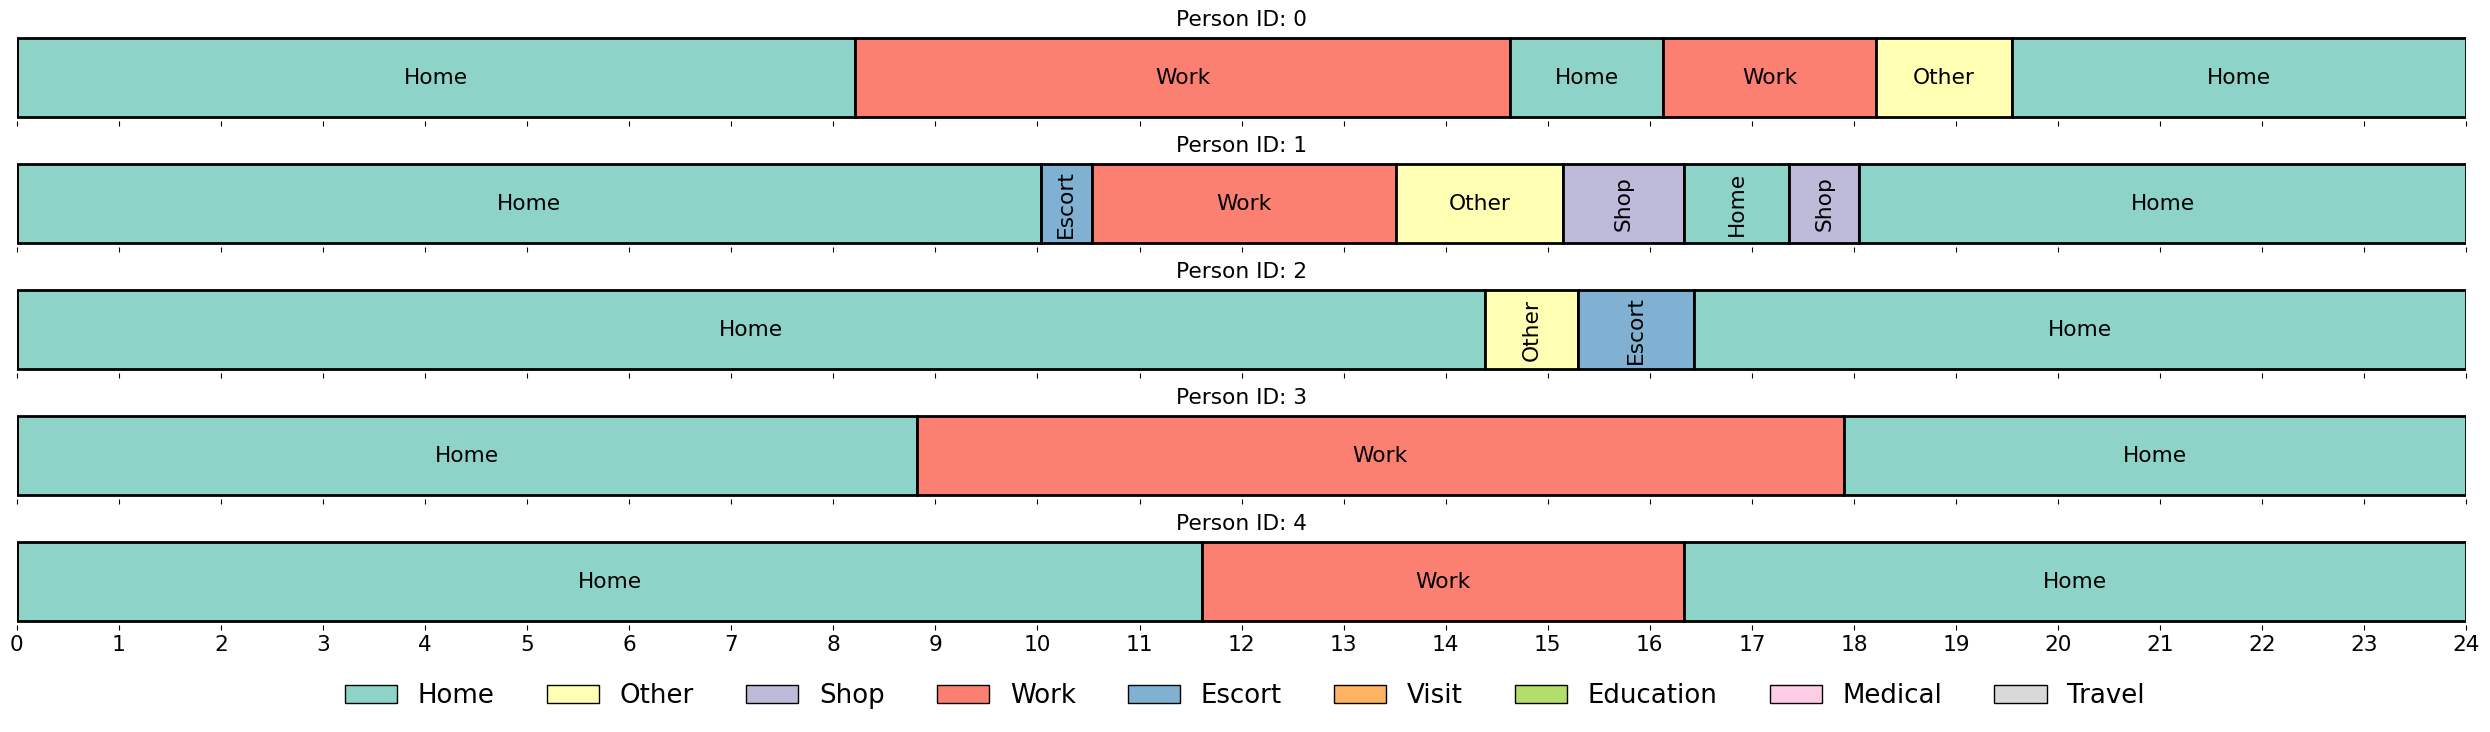

In [37]:
for n, p in batch_paths.items():
    examples = pd.read_csv(next(find_nth(p))[1] / "synthetic_schedules.csv")
    plot_schedules(examples)

In [38]:
def split_on(schedules, attributes, by="work_status"):
    splits = attributes.groupby(by)
    return {
        k.title(): schedules.loc[schedules.pid.isin(list(v.pid))]
        for k, v in splits
    }

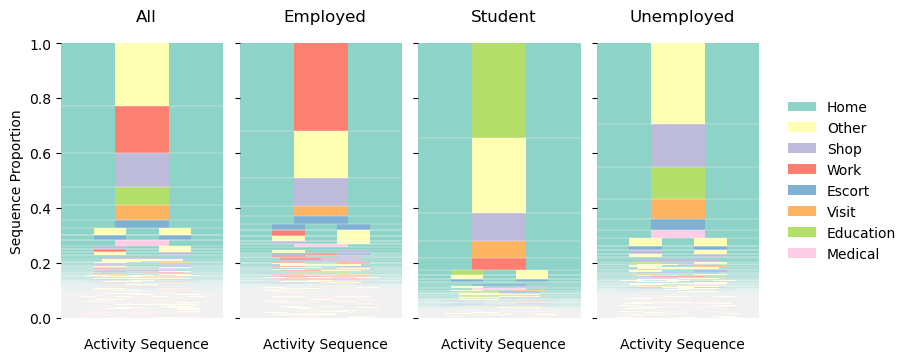

In [39]:
splits = split_on(target_schedules, target_attributes)
fig = transitions.sequence_prob_plot(
    target_schedules, splits, observed_title="All", cmap=cmap, figsize=(9, 3.5)
)

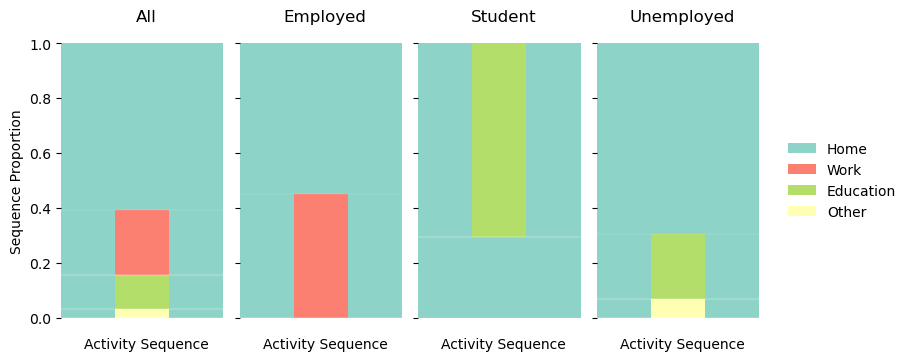

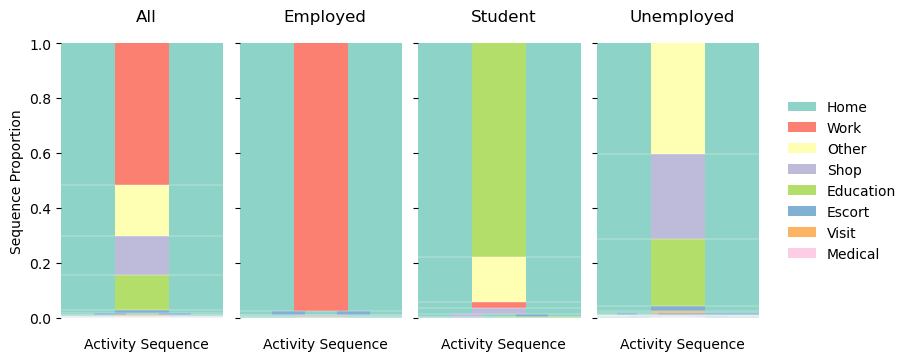

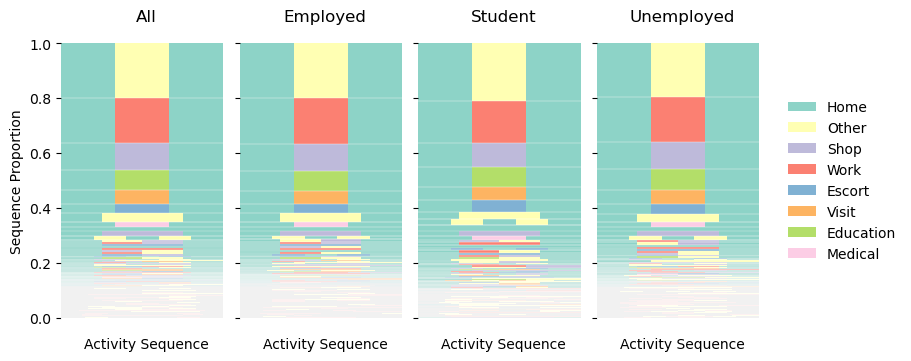

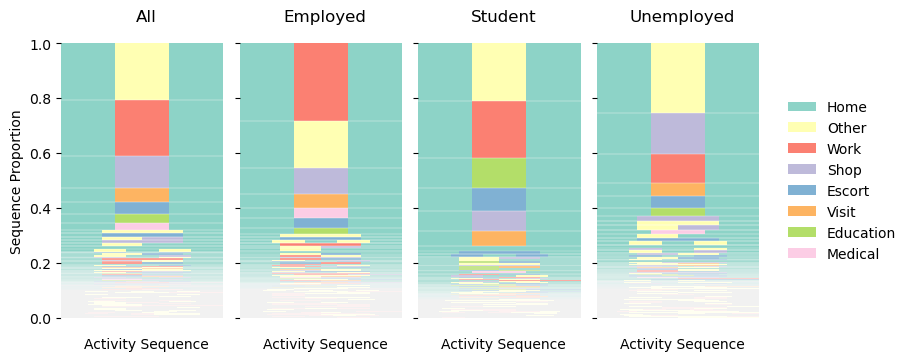

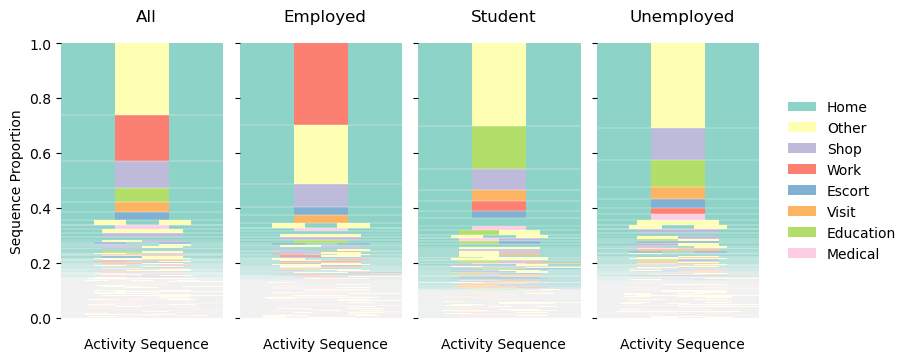

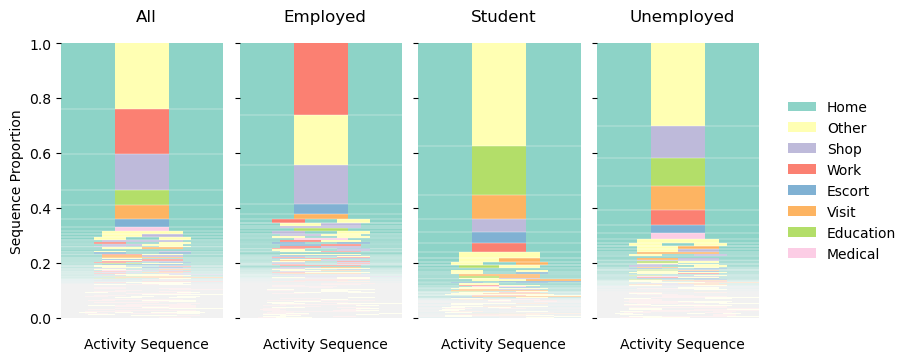

In [40]:
for k, scheds in schedules.items():
    splits = split_on(scheds, attributes[k])
    fig = transitions.sequence_prob_plot(
        scheds, splits, observed_title="All", cmap=cmap, figsize=(9, 3.5)
    )

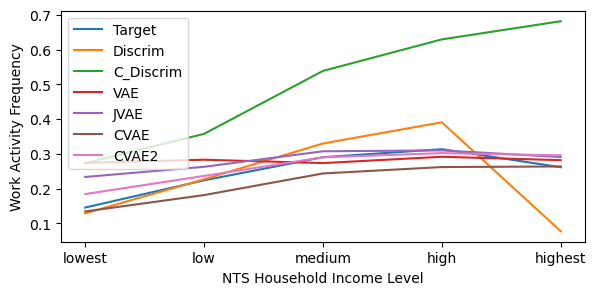

In [41]:
def split_on(schedules, attributes, by="work_status"):
    splits = attributes.groupby(by)
    return {
        k: schedules.loc[schedules.pid.isin(list(v.pid))] for k, v in splits
    }


def count_trips(schedules):
    n = schedules.pid.nunique()
    return (len(schedules) - n) / n


def count_acts(schedules, act="work"):
    n = schedules.pid.nunique()
    return len(split.loc[split.act == act]) / n


splits = split_on(target_schedules, target_attributes, by="income")
data = {"Target": {}}
for i, split in splits.items():
    data["Target"][i] = count_acts(split)


for n, scheds in schedules.items():
    data[n] = {}
    atts = attributes[n]
    splits = split_on(scheds, atts, by="income")
    for i, split in splits.items():
        data[n][i] = count_acts(split)

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(9 * 0.75, 3))
df.plot(ax=ax)
ax.set_ylabel("Work Activity Frequency")
ax.set_xlabel("NTS Household Income Level")
ax.set_xticks([1, 2, 3, 4, 5], ["lowest", "low", "medium", "high", "highest"])

Text(0.5, 0, 'Age Group')

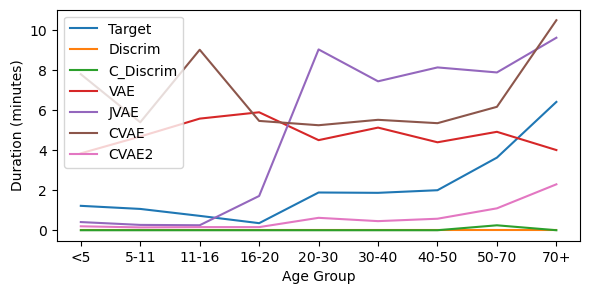

In [42]:
def norm_first(df):
    start = df.first().end / df.last().end
    return start


def first_act_start(schedules):
    return schedules.groupby("pid").norm_first().mean()


def meds(schedules):
    n = schedules.pid.nunique()
    return schedules[schedules.act == "medical"].duration.sum() / n


def time_at_home(schedules):
    return schedules.loc[schedules.act == "home"].duration.mean()


splits = split_on(target_schedules, target_attributes, by="age_group")
data = {"Target": {}}
for i, split in splits.items():
    data["Target"][i] = meds(split)

for n, scheds in schedules.items():
    data[n] = {}
    atts = attributes[n]
    splits = split_on(scheds, atts, by="age_group")
    for i, split in splits.items():
        data[n][i] = meds(split)

order = [
    "<5",
    "5-11",
    "11-16",
    "16-20",
    "20-30",
    "30-40",
    "40-50",
    "50-70",
    "70+",
]

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(9 * 0.75, 3))
df.loc[order].plot(ax=ax)
ax.set_ylabel("Duration (minutes)")
ax.set_xlabel("Age Group")

In [18]:
target_attributes.head()

,Unnamed: 0,pid,age,gender,ethnicity,education,license,car_access,work_status,area,income,hh_size,hh_composition,hh_children,hh_cars,hh_bikes,hh_motorcycles,age_group
0,0,0,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
1,1,1,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
2,2,2,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
3,3,3,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70
4,4,4,50,M,white,N,yes,yes,unemployed,urban,1,1,1adult,0,1.0,0,0.0,50-70


In [19]:
def build_distance_tables(batch_paths, suffix=""):
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():
        distances = pd.read_csv(
            path / f"domain_distances{suffix}.csv"
        ).set_index("domain")

        columns = list(
            set(distances.columns) - set(["domain", "observed", "mean", "std"])
        )
        distances_combined[(name, "EMD")] = distances[columns].mean(axis=1)
        distances_combined[(name, "var")] = distances[columns].var(axis=1)

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    # distances_combined = distances_combined.set_index(
    #     pd.MultiIndex.from_tuples(distances_combined.index)
    # )

    return distances_combined


df = build_distance_tables(batch_paths, suffix="")
print(df[::-1].to_latex(float_format="{:.3f}".format))
df

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & EMD & var & EMD & var & EMD & var & EMD & var & EMD & var \\
domain &  &  &  &  &  &  &  &  &  &  \\
\midrule
aggregate & 0.037 & 0.000 & 0.038 & 0.000 & 0.018 & 0.000 & 0.018 & 0.000 & 0.020 & 0.000 \\
count & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 2364.000 & 0.000 & 0.000 & 0.000 \\
creativity & 0.662 & 0.000 & 0.498 & 0.000 & 0.068 & 0.000 & 0.074 & 0.000 & 0.056 & 0.000 \\
participations & 0.696 & 0.001 & 0.229 & 0.000 & 0.084 & 0.000 & 0.083 & 0.000 & 0.070 & 0.000 \\
sample quality & 0.000 & 0.000 & 0.004 & 0.000 & 0.013 & 0.000 & 0.012 & 0.000 & 0.012 & 0.000 \\
timing & 0.284 & 0.000 & 0.141 & 0.000 & 0.059 & 0.000 & 0.060 & 0.000 & 0.059 & 0.000 \\
transitions & 0.034 & 0.000 & 0.028 & 0.000 & 0.007 & 0.000 & 0.007 & 0.000 & 0.007 & 0.000 \\
\bottomrule
\end{tabular}



Discrim               C_Discrim                     VAE  \
                     EMD           var       EMD           var       EMD   
domain                                                                     
aggregate       0.037235  2.111578e-05  0.038348  6.911127e-06  0.018204   
count           0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
creativity      0.662072  4.474691e-04  0.498289  5.072930e-06  0.067705   
participations  0.696249  5.914686e-04  0.229337  1.091331e-04  0.083878   
sample quality  0.000000  0.000000e+00  0.003556  5.359972e-06  0.013266   
timing          0.283992  3.881879e-04  0.140544  1.414345e-04  0.058801   
transitions     0.033972  1.525426e-07  0.027846  3.697217e-07  0.007061   

                                     JVAE                    CVAE  \
                         var          EMD           var       EMD   
domain                                                              
aggregate       1.312122e-06     0.018249  1.961841e-06  0.019841   
count           0.000000e+00  2364.000000  0.000000e+00  0.000000   
creativity      3.805226e-05     0.073853  9.183283e-05  0.055527   
participations  3.720802e-04     0.083256  2.114183e-04  0.070483   
sample quality  1.812631e-06     0.011968  6.459539e-06  0.011801   
timing          1.731639e-06     0.060291  6.765149e-06  0.058806   
transitions     6.241252e-07     0.006906  5.475949e-07  0.006527   

                              
                         var  
domain                        
aggregate       2.561696e-06  
count           0.000000e+00  
creativity      3.685507e-05  
participations  1.419053e-04  
sample quality  3.752077e-06  
timing          5.126928e-06  
transitions     3.726661e-07

In [21]:
df = build_distance_tables(batch_paths, suffix="_subs")
print(df[::-1].to_latex(float_format="{:.3f}".format))
df

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & EMD & var & EMD & var & EMD & var & EMD & var & EMD & var \\
domain &  &  &  &  &  &  &  &  &  &  \\
\midrule
aggregate & 0.043 & 0.000 & 0.045 & 0.000 & 0.022 & 0.000 & 0.022 & 0.000 & 0.023 & 0.000 \\
count & 537.273 & 0.000 & 537.273 & 0.000 & 537.273 & 0.000 & 537.273 & 0.000 & 537.273 & 0.000 \\
creativity & 0.546 & 0.000 & 0.464 & 0.000 & 0.020 & 0.000 & 0.023 & 0.000 & 0.015 & 0.000 \\
participations & 0.663 & 0.001 & 0.201 & 0.000 & 0.094 & 0.000 & 0.096 & 0.000 & 0.087 & 0.000 \\
sample quality & 0.000 & 0.000 & 0.004 & 0.000 & 0.013 & 0.000 & 0.012 & 0.000 & 0.012 & 0.000 \\
timing & 0.277 & 0.000 & 0.140 & 0.000 & 0.063 & 0.000 & 0.065 & 0.000 & 0.063 & 0.000 \\
transitions & 0.047 & 0.000 & 0.041 & 0.000 & 0.017 & 0.000 & 0.017 & 0.000 & 0.017 & 0.000 \\
\bottomrule
\end{tabular}



Discrim                 C_Discrim                \
                       EMD           var         EMD           var   
domain                                                               
aggregate         0.042978  2.065585e-05    0.044881  7.221343e-06   
count           537.272727  0.000000e+00  537.272727  0.000000e+00   
creativity        0.545784  3.454681e-05    0.464403  2.770709e-07   
participations    0.663449  5.600786e-04    0.200509  6.786449e-05   
sample quality    0.000000  0.000000e+00    0.003610  6.347493e-06   
timing            0.277149  3.817130e-04    0.140208  1.233252e-04   
transitions       0.046874  9.547535e-07    0.041086  7.230686e-07   

                       VAE                      JVAE                \
                       EMD           var         EMD           var   
domain                                                               
aggregate         0.021755  1.198153e-06    0.022051  1.543978e-06   
count           537.272727  0.000000e+00  537.272727  0.000000e+00   
creativity        0.019653  2.060771e-06    0.023128  1.570982e-05   
participations    0.094417  1.065421e-04    0.096285  7.957049e-05   
sample quality    0.013128  3.052802e-06    0.011755  7.142948e-06   
timing            0.062591  5.197593e-07    0.064602  5.100494e-06   
transitions       0.016707  5.091604e-07    0.016779  7.599610e-07   

                      CVAE                
                       EMD           var  
domain                                    
aggregate         0.023470  2.033735e-06  
count           537.272727  0.000000e+00  
creativity        0.014982  3.764833e-06  
participations    0.086831  5.968842e-05  
sample quality    0.011838  4.389258e-06  
timing            0.062507  4.104722e-06  
transitions       0.016507  5.780627e-07

In [22]:
def build_feature_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "feature_descriptions.csv").set_index(
            ["domain", "feature"]
        )
        distances = pd.read_csv(path / "feature_distances.csv").set_index(
            ["domain", "feature"]
        )
        print(distances.columns)

        columns = set(descriptions.columns)
        columns = list(
            columns - set(["observed", "description", "mean", "std"])
        )
        assert len(columns) == 5

        descriptions_combined[(name, "mean")] = descriptions[columns].mean(
            axis=1
        )
        # descriptions_combined[(name, "var")] = descriptions[columns].var(axis=1)
        descriptions_combined[(name, "EMD")] = distances[columns].mean(axis=1)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined[("Observed", "")] = descriptions["observed"]
    descriptions_combined[("Description", "")] = descriptions["description"]

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_feature_description_tables(batch_paths)
table

Index(['observed', 'discrim_nrun0', 'discrim_nrun1', 'discrim_nrun2',
       'discrim_nrun3', 'discrim_nrun4', 'distance'],
      dtype='object')
Index(['observed', 'c_discrim_nrun0', 'c_discrim_nrun1', 'c_discrim_nrun2',
       'c_discrim_nrun3', 'c_discrim_nrun4', 'distance'],
      dtype='object')
Index(['observed', 'vae_nrun0', 'vae_nrun1', 'vae_nrun2', 'vae_nrun3',
       'vae_nrun4', 'distance'],
      dtype='object')
Index(['observed', 'jvae_nrun0', 'jvae_nrun1', 'jvae_nrun2', 'jvae_nrun3',
       'jvae_nrun4', 'distance'],
      dtype='object')
Index(['observed', 'cvae_nrun0', 'cvae_nrun1', 'cvae_nrun2', 'cvae_nrun3',
       'cvae_nrun4', 'distance'],
      dtype='object')


Observed   Discrim            \
                                                      mean       EMD   
domain         feature                                                 
creativity     diversity                0.549724  0.002536       NaN   
               novelty                  1.000000  0.673321       NaN   
sample quality duration                 1.000000  1.000000  0.000000   
               home based               1.000000  1.000000  0.000000   
aggregate      agg. frequency           0.688881  0.850162  0.037235   
participations lengths                  3.680427  1.694655  1.985772   
               pair participation rate  0.038617  0.052776  0.041723   
               participation rate       0.085591  0.371599  0.061253   
transitions    2-gram                   0.041891  0.467848  0.060802   
               3-gram                   0.005097  0.417848  0.007142   
timing         durations                0.271708  0.590901  0.186616   
               end times                0.683808  0.808847  0.308393   
               start times              0.412100  0.217946  0.165245   
               start-durations          0.689380  0.815755  0.475714   

                                       C_Discrim                 VAE  \
                                            mean       EMD      mean   
domain         feature                                                 
creativity     diversity                0.008867       NaN  0.873393   
               novelty                  0.994555       NaN  0.991196   
sample quality duration                 1.000000  0.000000  1.000000   
               home based               0.992889  0.007111  0.973468   
aggregate      agg. frequency           0.715387  0.038348  0.647458   
participations lengths                  3.089541  0.637495  3.458157   
               pair participation rate  0.038354  0.012147  0.036516   
               participation rate       0.166995  0.038367  0.082639   
transitions    2-gram                   0.143370  0.048924  0.041609   
               3-gram                   0.095171  0.006767  0.004946   
timing         durations                0.323700  0.105176  0.289243   
               end times                0.771100  0.136354  0.707274   
               start times              0.447400  0.125348  0.418031   
               start-durations          0.773279  0.195298  0.709384   

                                                      JVAE            \
                                             EMD      mean       EMD   
domain         feature                                                 
creativity     diversity                     NaN  0.861531       NaN   
               novelty                       NaN  0.990763       NaN   
sample quality duration                 0.000000  1.000000  0.000000   
               home based               0.026532  0.976063  0.023937   
aggregate      agg. frequency           0.018204  0.658967  0.018249   
participations lengths                  0.236541  3.474621  0.235219   
               pair participation rate  0.005876  0.036661  0.005869   
               participation rate       0.009216  0.080455  0.008679   
transitions    2-gram                   0.011516  0.043167  0.011045   
               3-gram                   0.002605  0.005512  0.002768   
timing         durations                0.051416  0.287852  0.051879   
               end times                0.052183  0.707308  0.054168   
               start times              0.040667  0.419455  0.042081   
               start-durations          0.090939  0.709411  0.093038   

                                            CVAE              Description  
                                            mean       EMD                 
domain         feature                                                     
creativity     diversity                0.898853       NaN   prob. unique  
               novelty                  0.990093       NaN   

In [23]:
for n in ["aggregate", "participations", "transitions", "timing"]:
    print(n)
    print(table.loc[n].to_latex(float_format="{:.3f}".format))
    print()

aggregate
\begin{tabular}{lrrrrrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrim} & \multicolumn{2}{r}{C_Discrim} & \multicolumn{2}{r}{VAE} & \multicolumn{2}{r}{JVAE} & \multicolumn{2}{r}{CVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD & mean & EMD & mean & EMD &  \\
feature &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
agg. frequency & 0.689 & 0.850 & 0.037 & 0.715 & 0.038 & 0.647 & 0.018 & 0.659 & 0.018 & 0.651 & 0.020 & average freq. \\
\bottomrule
\end{tabular}


participations
\begin{tabular}{lrrrrrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrim} & \multicolumn{2}{r}{C_Discrim} & \multicolumn{2}{r}{VAE} & \multicolumn{2}{r}{JVAE} & \multicolumn{2}{r}{CVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD & mean & EMD & mean & EMD &  \\
feature &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
lengths & 3.680 & 1.695 & 1.986 & 3.090 & 0.637 & 3.458 & 0.237 & 3.475 & 0.235 & 3.527 & 0.196 & length. \\
pair participation rate & 0.039 

In [24]:
def build_creativity_table(batch_paths):
    descriptions_combined = pd.DataFrame()
    distances_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = (
            pd.read_csv(path / "descriptions.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )
        distances = (
            pd.read_csv(path / "distances.csv")
            .set_index(["domain", "feature", "segment"])
            .loc["creativity"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "desc."] = descriptions[columns].mean(
            axis=1
        )

        distances_combined[name, "dist."] = distances[columns].mean(axis=1)

    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    print(descriptions_combined.columns)

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    distances_combined["Observed", ""] = distances["observed"]
    distances_combined["Description", ""] = distances["distance"]

    distances_combined.columns = pd.MultiIndex.from_tuples(
        distances_combined.columns
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    descriptions_combined = descriptions_combined.loc[:, order]

    order = list(distances_combined.columns)
    order.pop(order.index(("Observed", "")))
    order.pop(order.index(("Description", "")))
    order = [("Observed", "")] + order + [("Description", "")]
    distances_combined = distances_combined.loc[:, order]

    return pd.concat((descriptions_combined, distances_combined), axis=0)


table = build_creativity_table(batch_paths)
table

Index([  ('Discrim', 'desc.'), ('C_Discrim', 'desc.'),       ('VAE', 'desc.'),
            ('JVAE', 'desc.'),      ('CVAE', 'desc.'),       ('Observed', ''),
          ('Description', '')],
      dtype='object')


,,Observed,Discrim,C_Discrim,VAE,JVAE,CVAE,Description,Discrim,C_Discrim,VAE,JVAE,CVAE
,,,desc.,desc.,desc.,desc.,desc.,,dist.,dist.,dist.,dist.,dist.
feature,segment,,,,,,,,,,,,
diversity,all,0.549724,0.002536,0.008867,0.873393,0.861531,0.898853,prob. unique,NaN,NaN,NaN,NaN,NaN
novelty,all,1.000000,0.673321,0.994555,0.991196,0.990763,0.990093,prob. novel,NaN,NaN,NaN,NaN,NaN
homogeneity,all,0.450276,NaN,NaN,NaN,NaN,NaN,prob. not unique,0.997464,0.991133,0.126607,0.138469,0.101147
conservatism,all,0.000000,NaN,NaN,NaN,NaN,NaN,prob. conservative,0.326679,0.005445,0.008804,0.009237,0.009907


In [25]:
def build_all_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions.csv").set_index(
            ["domain", "feature", "segment"]
        )
        distances = pd.read_csv(path / "distances.csv").set_index(
            ["domain", "feature", "segment"]
        )

        columns = set(descriptions.columns)
        weights = set([c for c in columns if "weight" in c])
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
            - weights
        )

        descriptions_combined[name, "mean"] = descriptions[columns].mean(axis=1)
        # descriptions_combined[name, "var"] = descriptions[columns].var(axis=1)
        descriptions_combined[name, "EMD"] = distances[columns].mean(axis=1)

    descriptions_combined["weight", ""] = distances["observed__weight"]
    descriptions_combined["Observed", ""] = descriptions["observed"]
    descriptions_combined["Description", ""] = descriptions["description"]

    descriptions_combined.columns = pd.MultiIndex.from_tuples(
        descriptions_combined.columns
    )

    descriptions_combined = descriptions_combined.groupby(
        ["domain", "feature"], group_keys=False
    ).apply(
        lambda x: x.sort_values(
            [("weight", ""), ("Observed", "")], ascending=False
        ).head(20)
    )
    descriptions_combined = descriptions_combined.drop(("weight", ""), axis=1)

    order = list(descriptions_combined.columns)
    order.pop(order.index(("Observed", "")))
    order = [("Observed", "")] + order

    index = [
        "aggregate",
        "participations",
        "transitions",
        "timing",
        "sample quality",
        "creativity",
    ]

    return descriptions_combined.loc[index, order]


table = build_all_description_tables(batch_paths)

In [26]:
print(table.loc["sample quality"].to_latex(float_format="{:.3f}".format))
table.loc["sample quality"]

\begin{tabular}{llrrrrrrrrrrrl}
\toprule
 &  & Observed & \multicolumn{2}{r}{Discrim} & \multicolumn{2}{r}{C_Discrim} & \multicolumn{2}{r}{VAE} & \multicolumn{2}{r}{JVAE} & \multicolumn{2}{r}{CVAE} & Description \\
 &  &  & mean & EMD & mean & EMD & mean & EMD & mean & EMD & mean & EMD &  \\
feature & segment &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
duration & total duration & 1.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & duration \\
\cline{1-14}
\multirow[t]{2}{*}{home based} & first act home & 1.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & prob. \\
 & last act home & 1.000 & 1.000 & 0.000 & 0.986 & 0.014 & 0.947 & 0.053 & 0.952 & 0.048 & 0.953 & 0.047 & prob. \\
\cline{1-14}
\bottomrule
\end{tabular}



Observed Discrim      C_Discrim                 VAE  \
                                      mean  EMD      mean       EMD      mean   
feature    segment                                                              
duration   total duration      1.0     1.0  0.0  1.000000  0.000000  1.000000   
home based first act home      1.0     1.0  0.0  1.000000  0.000000  0.999995   
           last act home       1.0     1.0  0.0  0.985777  0.014223  0.946942   

                                         JVAE                CVAE            \
                                EMD      mean       EMD      mean       EMD   
feature    segment                                                            
duration   total duration  0.000000  1.000000  0.000000  1.000000  0.000000   
home based first act home  0.000005  0.999989  0.000011  1.000000  0.000000   
           last act home   0.053058  0.952138  0.047862  0.952796  0.047204   

                          Description  
                                       
feature    segment                     
duration   total duration    duration  
home based first act home       prob.  
           last act home        prob.

In [27]:
table.loc["creativity"]

Observed   Discrim     C_Discrim           VAE      \
                                 mean EMD      mean EMD      mean EMD   
feature   segment                                                       
diversity all      0.549724  0.002536 NaN  0.008867 NaN  0.873393 NaN   
novelty   all      1.000000  0.673321 NaN  0.994555 NaN  0.991196 NaN   

                       JVAE          CVAE       Description  
                       mean EMD      mean EMD                
feature   segment                                            
diversity all      0.861531 NaN  0.898853 NaN  prob. unique  
novelty   all      0.990763 NaN  0.990093 NaN   prob. novel

In [28]:
p = table.loc["participations"]
for name in ["lengths", "participation rate", "pair participation rate"]:
    print(name)
    print(p.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["participations"]

lengths
\begin{tabular}{lrrrrrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrim} & \multicolumn{2}{r}{C_Discrim} & \multicolumn{2}{r}{VAE} & \multicolumn{2}{r}{JVAE} & \multicolumn{2}{r}{CVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
sequence lengths & 3.680 & 1.695 & 1.986 & 3.090 & 0.637 & 3.458 & 0.237 & 3.475 & 0.235 & 3.527 & 0.196 & length. \\
\bottomrule
\end{tabular}


participation rate
\begin{tabular}{lrrrrrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrim} & \multicolumn{2}{r}{C_Discrim} & \multicolumn{2}{r}{VAE} & \multicolumn{2}{r}{JVAE} & \multicolumn{2}{r}{CVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
home0 & 1.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 & av. rate \\
home1 & 1.000 & 0.347 & 0.653 & 0.9

Observed   Discrim            \
                                                        mean       EMD   
feature                 segment                                          
lengths                 sequence lengths  3.680427  1.694655  1.985772   
pair participation rate home+home         1.039565  0.346631  0.692934   
                        escort+escort     0.069613  0.000000  0.069613   
                        home+escort       0.067201  0.000000  0.067201   
                        other+other       0.056318  0.000000  0.056318   
                        home+other        0.055246  0.000000  0.055246   
                        shop+shop         0.023401  0.000000  0.023401   
                        home+shop         0.023160  0.000000  0.023160   
                        work+work         0.013027  0.000418  0.012609   
                        home+work         0.011982  0.000418  0.011564   
                        visit+visit       0.009864  0.000000  0.009864   
                        home+visit        0.009784  0.000000  0.009784   
                        escort+other      0.002493  0.000000  0.002493   
                        shop+escort       0.001447  0.000000  0.001447   
                        shop+other        0.001153  0.000000  0.001153   
                        home+medical      0.001019  0.000000  0.001019   
                        medical+medical   0.001019  0.000000  0.001019   
                        work+escort       0.000911  0.000000  0.000911   
                        escort+visit      0.000697  0.000000  0.000697   
                        other+visit       0.000563  0.000000  0.000563   
                        shop+visit        0.000536  0.000000  0.000536   
participation rate      home0             1.000000  1.000000  0.000000   
                        home1             0.999786  0.346631  0.653155   
                        other0            0.393690  0.006031  0.387659   
                        work0             0.237174  0.215788  0.023476   
                        shop0             0.232510  0.000000  0.232510   
                        home2             0.205624  0.000697  0.204927   
                        escort0           0.139897  0.000000  0.139897   
                        visit0            0.109419  0.000000  0.109419   
                        education0        0.074814  0.124811  0.049997   
                        escort1           0.064762  0.000000  0.064762   
                        other1            0.054361  0.000000  0.054361   
                        home3             0.038332  0.000000  0.038332   
                        medical0          0.037233  0.000000  0.037233   
                        shop1             0.022999  0.000000  0.022999   
                        work1             0.011768  0.000418  0.011349   
                        escort2           0.011419  0.000000  0.011419   
                        other2            0.010293  0.000000  0.010293   
                        visit1            0.009757  0.000000  0.009757   
                        home4             0.005763  0.000000  0.005763   
                        escort3           0.004316  0.000000  0.004316   

                                         C_Discrim                 VAE  \
                                              mean       EMD      mean   
feature                 segment                                          
lengths                 sequence lengths  3.089541  0.637495  3.458157   
pair participation rate home+home         0.990666  0.048898  0.958940   
                        escort+escort     0.050357  0.072021  0.044754   
                        home+escort       0.009639  0.057562  0.037726   
                        other+other       0.000000  0.056318  0.065727   
                        home+other        0.000000  0.055246  0.056656   
                        shop+shop         0.000000  0.023401  0.035549   
                        home+shop         0.0

In [29]:
t = table.loc["transitions"]
for name in ["2-gram", "3-gram"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["transitions"]

2-gram
\begin{tabular}{lrrrrrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrim} & \multicolumn{2}{r}{C_Discrim} & \multicolumn{2}{r}{VAE} & \multicolumn{2}{r}{JVAE} & \multicolumn{2}{r}{CVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
other>home & 0.414 & 0.015 & 0.399 & 0.222 & 0.192 & 0.346 & 0.068 & 0.361 & 0.053 & 0.388 & 0.045 & av. rate \\
home>other & 0.414 & 0.015 & 0.399 & 0.223 & 0.192 & 0.352 & 0.062 & 0.381 & 0.038 & 0.402 & 0.044 & av. rate \\
home>work & 0.229 & 0.622 & 0.403 & 0.500 & 0.283 & 0.228 & 0.014 & 0.221 & 0.017 & 0.212 & 0.018 & av. rate \\
work>home & 0.225 & 0.622 & 0.407 & 0.500 & 0.287 & 0.196 & 0.029 & 0.205 & 0.023 & 0.192 & 0.033 & av. rate \\
shop>home & 0.224 & 0.000 & 0.224 & 0.123 & 0.101 & 0.180 & 0.044 & 0.175 & 0.049 & 0.186 & 0.039 & av. rate \\
home>shop & 0.213 & 0.000 & 0.213 & 0.123 & 0.090 & 0.175 & 0.038 & 0.172 & 0.041 & 0.189

Observed   Discrim           C_Discrim            \
                                           mean       EMD      mean       EMD   
feature segment                                                                 
2-gram  other>home           0.414365  0.015380  0.398985  0.222495  0.191870   
        home>other           0.414258  0.015380  0.398878  0.222522  0.191736   
        home>work            0.229288  0.622397  0.402578  0.500381  0.282621   
        work>home            0.224838  0.622397  0.407072  0.500381  0.287125   
        shop>home            0.224221  0.000000  0.224221  0.123181  0.101040   
        home>shop            0.213363  0.000000  0.213363  0.123181  0.090181   
        home>escort          0.177543  0.000000  0.177543  0.031276  0.146267   
        escort>home          0.168829  0.000000  0.168829  0.017086  0.151744   
        visit>home           0.102552  0.000000  0.102552  0.001871  0.100681   
        home>visit           0.093973  0.000000  0.093973  0.001833  0.092139   
        home>education       0.072738  0.364585  0.291933  0.128987  0.056356   
        education>home       0.070084  0.364585  0.294587  0.128944  0.058967   
        home>medical         0.034854  0.000000  0.034854  0.000172  0.034683   
        medical>home         0.031128  0.000000  0.031128  0.000172  0.030956   
        other>other          0.019170  0.000000  0.019170  0.000000  0.019170   
        escort>escort        0.019009  0.000000  0.019009  0.075012  0.063383   
        home>home            0.015443  0.000000  0.015443  0.000000  0.015443   
        shop>shop            0.014987  0.000000  0.014987  0.000000  0.014987   
        escort>work          0.010805  0.000000  0.010805  0.005972  0.006376   
        other>shop           0.010322  0.000000  0.010322  0.000000  0.010322   
3-gram  home>other>home      0.388414  0.015380  0.373033  0.222496  0.165918   
        home>work>home       0.214050  0.622397  0.416717  0.500383  0.296512   
        home>shop>home       0.192041  0.000000  0.192041  0.123182  0.068859   
        home>escort>home     0.136573  0.000000  0.136573  0.015563  0.121009   
        home>visit>home      0.081835  0.000000  0.081835  0.001834  0.080002   
        home>education>home  0.069383  0.364585  0.295289  0.128945  0.059671   
        other>home>other     0.038116  0.000000  0.038116  0.000000  0.038116   
        escort>home>escort   0.037466  0.000000  0.037466  0.008299  0.029167   
        home>medical>home    0.029074  0.000000  0.029074  0.000172  0.028903   
        shop>home>other      0.019870  0.000000  0.019870  0.000000  0.019870   
        other>home>shop      0.016351  0.000000  0.016351  0.000000  0.016351   
        work>home>other      0.014348  0.000000  0.014348  0.000000  0.014348   
        home>escort>escort   0.013508  0.000000  0.013508  0.009741  0.004940   
        other>home>escort    0.013508  0.000000  0.013508  0.000000  0.013508   
        escort>escort>home   0.012994  0.000000  0.012994  0.000000  0.012994   
        other>other>home     0.012994  0.000000  0.012994  0.000000  0.012994   
        home>other>other     0.012561  0.000000  0.012561  0.000000  0.012561   
        escort>home>other    0.012371  0.000000  0.012371  0.000000  0.012371   
        shop>shop>home       0.011911  0.000000  0.011911  0.000000  0.011911   
        home>shop>shop       0.011424  0.000000  0.011424  0.000000  0.011424   

                                  VAE                JVAE                CVAE  \
                                 mean       EMD      mean       EMD      mean   
feature segment                                                                 
2-gram  other>home           0.346147  0.068218  0.361306  0.053059  0.387991   
        home>other           0.352295  0.061963  0.380618  0.037708  0.402014   
        home>work            0.228043  0.013965  0.221048  0.016677  0.211505   
        work>home            0.196280  0.028557  0.205271  

In [30]:
t = table.loc["timing"]
for name in ["durations", "start times", "end times", "start-durations"]:
    print(name)
    print(t.loc[name].to_latex(float_format="{:.3f}".format))
    print()

table.loc["timing"]

durations
\begin{tabular}{lrrrrrrrrrrrl}
\toprule
 & Observed & \multicolumn{2}{r}{Discrim} & \multicolumn{2}{r}{C_Discrim} & \multicolumn{2}{r}{VAE} & \multicolumn{2}{r}{JVAE} & \multicolumn{2}{r}{CVAE} & Description \\
 &  & mean & EMD & mean & EMD & mean & EMD & mean & EMD & mean & EMD &  \\
segment &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
home0 & 0.458 & 0.798 & 0.341 & 0.580 & 0.133 & 0.486 & 0.054 & 0.491 & 0.060 & 0.491 & 0.060 & average \\
home1 & 0.307 & 0.351 & 0.098 & 0.260 & 0.107 & 0.303 & 0.058 & 0.303 & 0.055 & 0.298 & 0.054 & average \\
other0 & 0.079 & 0.010 & 0.073 & 0.077 & 0.023 & 0.106 & 0.046 & 0.094 & 0.045 & 0.099 & 0.043 & average \\
work0 & 0.339 & 0.216 & 0.124 & 0.203 & 0.148 & 0.305 & 0.051 & 0.307 & 0.049 & 0.312 & 0.044 & average \\
shop0 & 0.051 & 0.000 & 0.051 & 0.047 & 0.015 & 0.085 & 0.035 & 0.077 & 0.027 & 0.080 & 0.030 & average \\
home2 & 0.244 & 0.073 & 0.220 & 0.071 & 0.186 & 0.261 & 0.055 & 0.260 & 0.056 & 0.252 & 0.057 & average \\
escor

Observed   Discrim           C_Discrim            \
                                         mean       EMD      mean       EMD   
feature         segment                                                       
durations       home0      0.457594  0.798220  0.340626  0.580188  0.132787   
                home1      0.306878  0.351218  0.097601  0.260360  0.107076   
                other0     0.079479  0.009898  0.073356  0.077149  0.023429   
                work0      0.338817  0.216464  0.124027  0.203104  0.147541   
                shop0      0.051317  0.000000  0.051317  0.047075  0.014865   
...                             ...       ...       ...       ...       ...   
start-durations work       0.708265  0.657659  0.200118  0.756513  0.323562   
                escort     0.568512  0.000000  0.568512  0.755108  0.192151   
                visit      0.697188  0.000000  0.697188  0.571619  0.296238   
                education  0.659623  0.644177  0.061512  0.752218  0.255779   
                medical    0.563979  0.000000  0.563979  0.133333  0.482714   

                                VAE                JVAE                CVAE  \
                               mean       EMD      mean       EMD      mean   
feature         segment                                                       
durations       home0      0.485816  0.054333  0.490857  0.060428  0.491050   
                home1      0.303020  0.057965  0.303367  0.055006  0.297935   
                other0     0.105672  0.046371  0.093919  0.045413  0.099236   
                work0      0.304620  0.050657  0.307403  0.048858  0.312283   
                shop0      0.084896  0.034841  0.076589  0.026704  0.079829   
...                             ...       ...       ...       ...       ...   
start-durations work       0.709992  0.096777  0.717760  0.099634  0.724791   
                escort     0.640373  0.090277  0.639782  0.099828  0.649700   
                visit      0.709694  0.085583  0.711676  0.091750  0.715583   
                education  0.676974  0.114508  0.686606  0.108893  0.690276   
                medical    0.634697  0.081827  0.662706  0.104227  0.655435   

                                    Description  
                                EMD              
feature         segment                          
durations       home0      0.059896     average  
                home1      0.054494     average  
                other0     0.042767     average  
                work0      0.044232     average  
                shop0      0.029867     average  
...                             ...         ...  
start-durations work       0.093040     average  
                escort     0.091316     average  
                visit      0.083443     average  
                education  0.103498     average  
                medical    0.098718     average  

[68 rows x 12 columns]

In [ ]:
print(table.to_latex(float_format="{:.3f}".format))

In [ ]:
for domain in [
    "creativity",
    "sample quality",
    "aggregate",
    "participations",
    "transitions",
    "timing",
]:
    print()
    print(domain)
    print()
    ss = table.loc[domain]
    for feature in set(ss.reset_index()["feature"]):
        print(feature)
        print()
        print(ss.loc[feature].to_latex(float_format="{:.3f}".format))

In [ ]:
def build_subs_description_tables(batch_paths):
    descriptions_combined = pd.DataFrame()

    for name, path in batch_paths.items():

        descriptions = pd.read_csv(path / "descriptions_subs.csv").set_index(
            ["domain", "feature", "segment", "sub_pop"]
        )
        columns = set(descriptions.columns)
        columns = list(
            columns
            - set(["observed", "description", "mean", "std", "feature count"])
        )

        descriptions_combined[name] = descriptions[columns].mean(axis=1)

    descriptions_combined["Observed"] = descriptions["observed"]
    descriptions_combined["Description"] = descriptions["description"]

    descriptions_combined = (
        descriptions_combined.sort_values("Observed", ascending=False)
        .groupby(["domain", "feature", "sub_pop"])
        .head(100)
    )

    order = list(descriptions_combined.columns)
    order.pop(order.index("Observed"))
    order = ["Observed"] + order

    index = [
        "creativity",
        "sample quality",
        "aggregate",
        "participations",
        "transitions",
        "timing",
    ]

    return descriptions_combined.loc[index, order]


table = build_subs_description_tables(batch_paths)
table

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "work0",
    ["work_status=student", "work_status=employed"],
]

In [ ]:
table.loc[
    "participations",
    "participation rate",
    "education0",
    ["work_status=student", "work_status=employed"],
]

In [ ]:
distances_subs.set_index(["domain", "feature", "sub_pop"]).loc["timing"]

In [ ]:
from caveat.evaluate.distance.wasserstein import emd
from caveat.evaluate.features.frequency import activity_frequencies

In [ ]:
sample = pd.read_csv("../logs/best_jm_z24/version_30/synthetic_schedules.csv")
target = pd.read_csv("../tmp/nts_home_schedules.csv")
sample.head()

In [ ]:
freqs = activity_frequencies(sample)
support, density = freqs["work"]
tsupport, tdensity = activity_frequencies(target)["work"]
emd((support, density), (tsupport, tdensity))

In [ ]:
from caveat.evaluate.describe.features import average_density

In [ ]:
average_density(freqs)

In [ ]:
tdensity

In [ ]:
import numpy as np

In [ ]:
np.arange(0, 1, 0.1)

In [ ]:
attributes = pd.read_csv("../tmp/nts_home_attributes.csv")
attributes.head()

In [ ]:
age_mapping = {
    1: 0,
    2: 1,
    3: 3,
    4: 5,
    5: 11,
    6: 16,
    7: 17,
    8: 18,
    9: 19,
    10: 20,
    11: 21,
    12: 26,
    13: 30,
    14: 40,
    15: 50,
    16: 60,
    17: 65,
    18: 70,
    19: 75,
    20: 80,
    21: 85,
}
age_to_idx = {v: k for k, v in age_mapping.items()}
age_group_mapping = {
    1: "<5",
    2: "<5",
    3: "<5",
    4: "5-11",
    5: "11-16",
    6: "16-20",
    7: "16-20",
    8: "16-20",
    9: "16-20",
    10: "20-30",
    11: "20-30",
    12: "20-30",
    13: "30-40",
    14: "40-50",
    15: "50-70",
    16: "50-70",
    17: "50-70",
    18: "70+",
    19: "70+",
    20: "70+",
    21: "70+",
}

attributes["age_group"] = attributes.age.map(age_to_idx).map(age_group_mapping)
attributes.head()
attributes.to_csv("../tmp/nts_home_attributes_groups.csv", index="pid")